In [12]:
# Import des librairies nécessaires
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt

# Astuce pour permettre l'import de vos fonctions depuis le dossier src/
# On ajoute le dossier parent (la racine du projet) au chemin de recherche de Python
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.utils import extract_all_labels

print("Analyse du jeu de données final...")

# --- On reproduit la logique de filtrage de train.py ---

# 1. Chargement des données brutes
full_df = pd.read_json("../data/train.json")

# 2. Filtrage pour ne garder que la prostate
prostate_df = full_df[full_df['report'].str.contains("Prostate, biopsy", case=False, na=False)].reset_index(drop=True)

# 3. Filtrage pour ne garder que les fichiers .parquet existants
features_path = "../data/features_histoencoder/train"
expected_filenames = prostate_df['id'].apply(lambda x: f"{x.replace('.tiff', '')}.parquet")
file_exists_mask = expected_filenames.apply(lambda x: os.path.exists(os.path.join(features_path, x)))
cleaned_df = prostate_df[file_exists_mask].reset_index(drop=True)

# 4. Extraction et filtrage des labels
labels_series = cleaned_df['report'].apply(extract_all_labels)
labels_df = pd.json_normalize(labels_series.tolist())
cleaned_df = cleaned_df.join(labels_df)
final_df = cleaned_df[(cleaned_df['gleason_score'] != -1) & (cleaned_df['grade_group'] != -1)].reset_index(drop=True)

print(f"\nNombre d'échantillons valides à analyser : {len(final_df)}")
print("\nAperçu des 5 premières lignes :")
final_df.head()

Analyse du jeu de données final...

Nombre d'échantillons valides à analyser : 385

Aperçu des 5 premières lignes :


,id,report,gleason_score,grade_group,tumor_volume
0,PIT_01_05664_01.tiff,"Prostate, biopsy;\n Acinar adenocarcinoma, Gl...",0,0,0.30
1,PIT_01_05675_01.tiff,"Prostate, biopsy;\n Acinar adenocarcinoma, Gl...",4,3,0.60
2,PIT_01_05683_01.tiff,"Prostate, biopsy;\n Acinar adenocarcinoma, Gl...",1,1,0.90
3,PIT_01_05689_01.tiff,"Prostate, biopsy;\n Acinar adenocarcinoma, Gl...",4,3,0.70
4,PIT_01_05690_01.tiff,"Prostate, biopsy;\n Acinar adenocarcinoma, Gl...",0,0,0.35



Distribution des Grade Groups :
grade_group
0    135
1     78
2     71
3     78
4     23
Name: count, dtype: int64


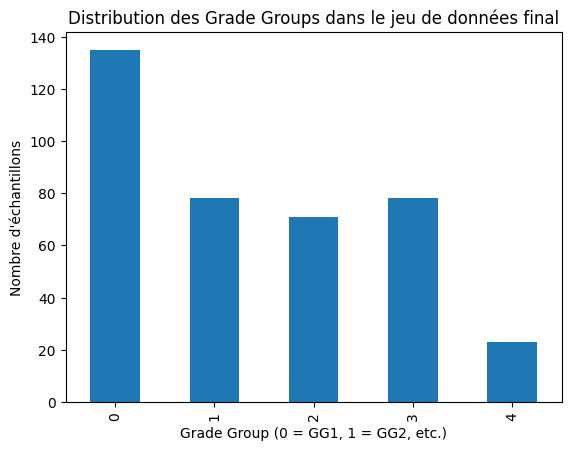

In [13]:
# Dans une nouvelle cellule
print("\nDistribution des Grade Groups :")
grade_group_counts = final_df['grade_group'].value_counts().sort_index()
print(grade_group_counts)

# Créer un histogramme
grade_group_counts.plot(kind='bar', title='Distribution des Grade Groups dans le jeu de données final')
plt.xlabel("Grade Group (0 = GG1, 1 = GG2, etc.)")
plt.ylabel("Nombre d'échantillons")
plt.show()

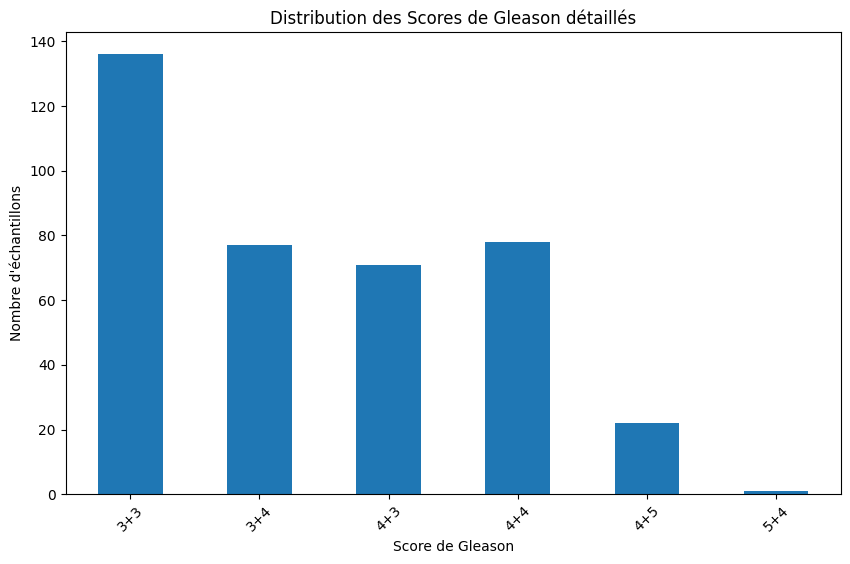

In [14]:
import matplotlib.pyplot as plt

# On s'assure que les labels de l'axe X seront lisibles
gleason_map_display = {
    0: "3+3", 1: "3+4", 2: "3+5", 3: "4+3", 4: "4+4", 5: "4+5",
    6: "5+3", 7: "5+4", 8: "5+5"
}

# On compte les occurrences de chaque score de Gleason
gleason_counts = final_df['gleason_score'].value_counts().sort_index()

# On remplace les numéros par les vrais scores pour l'affichage
gleason_counts.index = gleason_counts.index.map(gleason_map_display)

# On crée l'histogramme
gleason_counts.plot(kind='bar', figsize=(10, 6), title="Distribution des Scores de Gleason détaillés")
plt.xlabel("Score de Gleason")
plt.ylabel("Nombre d'échantillons")
plt.xticks(rotation=45)
plt.show()

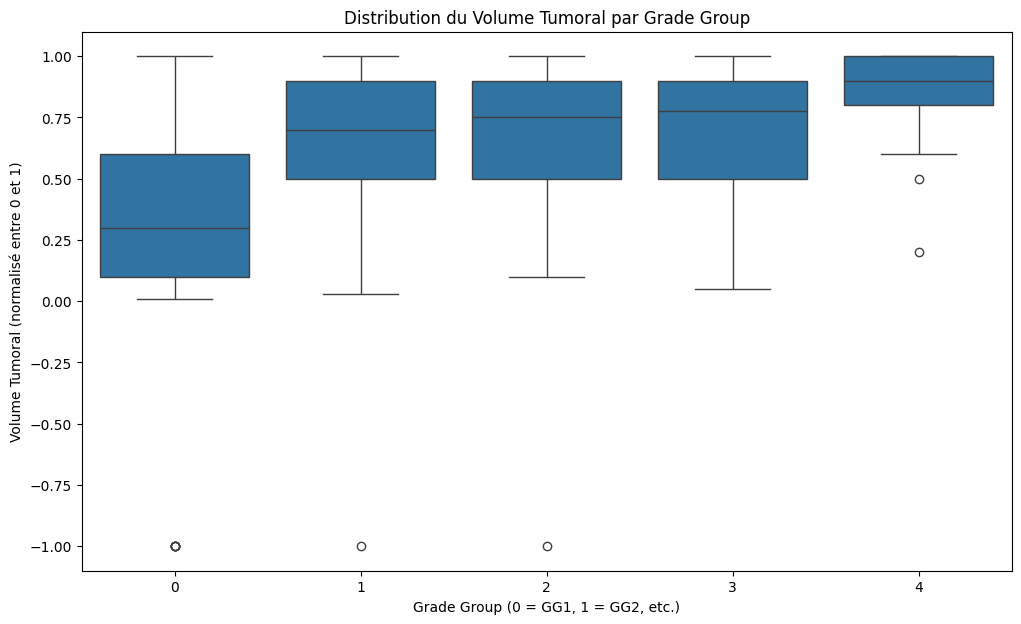

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# On crée un boxplot pour visualiser la distribution du volume pour chaque Grade Group
plt.figure(figsize=(12, 7))
sns.boxplot(x='grade_group', y='tumor_volume', data=final_df)

plt.title("Distribution du Volume Tumoral par Grade Group")
plt.xlabel("Grade Group (0 = GG1, 1 = GG2, etc.)")
plt.ylabel("Volume Tumoral (normalisé entre 0 et 1)")
plt.show()

In [16]:
from src.data_loader import WsiReportDataset

print("Création de l'objet Dataset et chargement des features en RAM...")
# On utilise le `final_df` et `features_path` qui ont été créés dans votre toute première cellule
full_dataset = WsiReportDataset(
    data_df=final_df,
    features_path=features_path,
    feature_type='parquet' # On utilise les nouvelles features
)
print("Chargement des features terminé.")

Création de l'objet Dataset et chargement des features en RAM...
Mode Parquet: Les features seront chargées et échantillonnées à la volée.
Chargement des features terminé.


Extraction des features de chaque échantillon du dataset...


100%|██████████| 385/385 [00:12<00:00, 29.85it/s]
c:\REG2025Project_armftn\venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Calcul de la projection t-SNE (cela peut prendre quelques minutes)...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 385 samples in 0.000s...
[t-SNE] Computed neighbors for 385 samples in 2.170s...
[t-SNE] Computed conditional probabilities for sample 385 / 385
[t-SNE] Mean sigma: 4.736070
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.576031
[t-SNE] KL divergence after 300 iterations: 0.821405


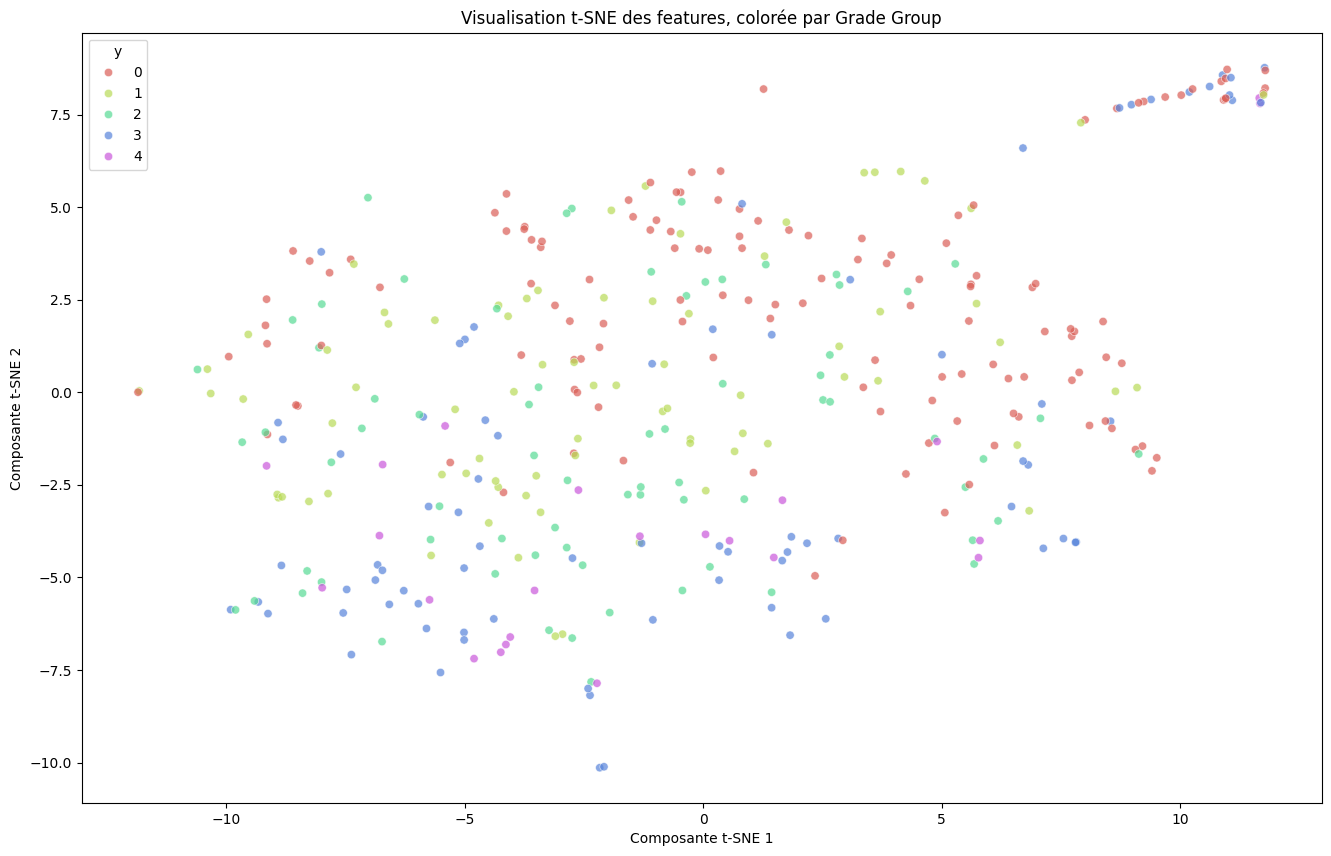

In [18]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# --- CORRECTION ---
# On ne peut plus utiliser `full_dataset.all_features`.
# On doit itérer sur le dataset pour récupérer les features de chaque échantillon.
print("Extraction des features de chaque échantillon du dataset...")

features_list = []
# On boucle sur le dataset avec une barre de progression
for sample in tqdm(full_dataset):
    features_list.append(sample['features'].numpy())
# --- FIN DE LA CORRECTION ---

# On continue comme avant : on prend la moyenne des patchs pour chaque lame pour simplifier
slide_features = np.array([f.mean(axis=0) for f in features_list])
labels_for_plot = final_df['grade_group'].values

print("Calcul de la projection t-SNE (cela peut prendre quelques minutes)...")
# On initialise l'algorithme t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
# On l'applique à nos features pour les réduire à 2 dimensions
tsne_results = tsne.fit_transform(slide_features)

# On crée un DataFrame pour un affichage facile avec seaborn
df_tsne = pd.DataFrame()
df_tsne['tsne-2d-one'] = tsne_results[:,0]
df_tsne['tsne-2d-two'] = tsne_results[:,1]
df_tsne['y'] = labels_for_plot

# On affiche le nuage de points
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 5), # 5 couleurs pour les 5 Grade Groups
    data=df_tsne,
    legend="full",
    alpha=0.7
)
plt.title("Visualisation t-SNE des features, colorée par Grade Group")
plt.xlabel("Composante t-SNE 1")
plt.ylabel("Composante t-SNE 2")
plt.show()